---
title: "Naïve Bayes"
author: Marion Bauman
format:
    html:
        embed-resources: true
---

## Introduction to Naïve Bayes

In this next section of the project, I will be using the Naïve Bayes algorithm to classify both textual and numerical data. The Naïve Bayes method is an algorithm based on Bayes' Theorem, which states that:

$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}.$$

From here we also know that

$$P(Y|X) \propto P(X|Y)P(Y).$$

Put differently, this means that the probability of $Y$ given $X$ is proportional to the probability of $X$ given $Y$ times the probability of $Y$. 

Generally, machine learning algorithms aim to find $P(Y|X)$, that is, to predict $Y$ given all features $X$. This is called discriminative learning. Naïve Bayes is different because it aims to do the opposite: find $P(X|Y)$ and $P(Y)$ in order to predict $Y$. We call this generative learning.

Naïve Bayes has the moniker "naïve" because it relies on a naïve assumption that is generally not true in practice. It assumes that all features in the data are independent of one another. While this assumption is rarely true, we can still get good results by using the Naïve Bayes model.

Naïve Bayes works by ...

Naïve Bayes works for numeric and textual data. For numeric data, we use a Gaussian Naïve Bayes model. Gaussian Naïve Bayes works by 

We use a Bernoulli Naïve Bayes (binary target) or Multinomial Naïve Bayes (multiclass target) model for factor data. Multinomial Naïve Bayes makes predictions by calculating the probability of the input value given each class. The class with the highest probability is then returned as the prediction.

In this section, I will use a Multinomial Naïve Bayes model to classify text data to determine which of the subreddits it belongs to out of r/Psychosis, r/schizophrenia, and r/weed. For the record data, I will use a Bernoulli Naïve Bayes to predict whether an individual uses cannabis based on their mental health data.

## Data Preparation

Now we prepare the data so that we can make predictions using the Naïve Bayes model.

In [54]:
import pandas as pd

reddit_text = pd.read_csv('../data/clean_data/reddit_cleaned_text.csv')
full_data = pd.read_csv('../data/clean_data/full_data.csv')

All of our data is already labeled as is required. The text data has already been cleaned, with each entry representing one post of Reddit. 

Our record data is mostly clean as well. Let's normalize everything so that no feature has an outsized impact on our model.

In [55]:
# scale all columns to be between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
full_data = full_data.apply(lambda x: pd.Series(scaler.fit_transform(x.values.reshape(-1,1)).reshape(-1), index=x.index))

/Users/mariongeary/anaconda3/envs/dsan5000/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/mariongeary/anaconda3/envs/dsan5000/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [56]:
full_data = full_data.drop(['cds0'], axis=1).dropna()
full_data.head()

,code,Program,sex,age_psychosis,family_history,hospita,dui,dup,levelsocioeco,urbanarea,...,unemployed,years_edu,CannabisBinary,SAPS0,Psychoticdim0,Disorganizeddim0,Negativedimen0,dasgl0,diagnosis,insight
0,0.000000,0.0,1.0,0.163471,1.0,1.0,0.006600,0.003918,0.0,0.0,...,1.0,0.545455,1.0,0.208333,0.4,0.133333,0.25,0.4,1.0,0.0
1,0.001305,0.0,0.0,0.396282,0.0,1.0,0.001389,0.001834,1.0,0.0,...,1.0,0.818182,1.0,0.333333,0.8,0.066667,0.20,0.0,1.0,0.0
3,0.003916,0.0,0.0,0.214728,1.0,1.0,0.062174,0.016421,1.0,0.0,...,1.0,0.545455,1.0,0.541667,0.8,0.400000,0.35,0.0,0.0,1.0
4,0.005222,0.0,0.0,0.146080,1.0,0.0,0.096909,0.049762,0.0,0.0,...,0.0,0.181818,1.0,0.416667,0.4,0.466667,0.90,0.4,0.0,1.0
5,0.006527,0.0,0.0,0.048563,1.0,0.0,0.003126,0.003918,1.0,1.0,...,1.0,0.181818,1.0,0.375000,0.4,0.400000,0.25,0.0,1.0,1.0


Now that our data is clean, we can split our data into training, validation, and test sets. We will use the training set to train our model, the validation set to tune our model, and the test set to evaluate our model. We split the data into 3 sets to avoid overfitting. If we train the model on all of our data, it will be too specific to our data and will not generalize well to new data. Without test data, we will not be able to assess the performance of our model. We also use validation data to tune our model by assessing hyperparameters based on data the model has not seen before.

In [57]:
## Split data into training, validation, and test sets
# 80% training, 10% validation, 10% test
train_full = full_data.sample(frac=0.8, random_state=200)
test_full = full_data.drop(train_full.index)
validate_full = test_full.sample(frac=0.5, random_state=200)
test_full = test_full.drop(validate_full.index)

In [58]:
## Split data into training, validation, and test sets
# 80% training, 10% validation, 10% test
train_reddit = reddit_text.sample(frac=0.8, random_state=200)
test_reddit = reddit_text.drop(train_reddit.index)
validate_reddit = test_reddit.sample(frac=0.5, random_state=200)
test_reddit = test_reddit.drop(validate_reddit.index)

## Feature Selection for Record Data

In [161]:
import numpy as np

y = train_full['CannabisBinary']
y = np.array(y)

In [162]:
x = train_full.drop(['CannabisBinary', 'code', 'Program'], axis=1).to_numpy()
x_test = test_full.drop(['CannabisBinary', 'code', 'Program'], axis=1).to_numpy()
x_validate = validate_full.drop(['CannabisBinary', 'code', 'Program'], axis=1).to_numpy()

In [163]:
y_test = test_full['CannabisBinary']
y_validate = validate_full['CannabisBinary']
y_test = np.array(y_test)
y_validate = np.array(y_validate)

In [164]:
x = full_data.drop(['CannabisBinary', 'code', 'Program'], axis=1).to_numpy()
y = full_data['CannabisBinary'].to_numpy()

In [165]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:] # last 20% of shuffled list

print(train_index[0:10])
print(test_index[0:10])

[125, 395, 203, 166, 197, 90, 95, 88, 69, 108]
[469, 32, 311, 433, 33, 514, 153, 112, 259, 497]


In [166]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X, Y, i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)

In [167]:
##UTILITY FUNCTION TO INITIALIZE RELEVANT ARRAYS
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

        if(i%1==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=19, min_index=0, max_index=19)

# # SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
# partial_grid_search(num_runs=20, min_index=1000, max_index=10000)

1 1 1 56.324582338902154 59.04761904761905
2 2 2 55.60859188544153 59.04761904761905
3 3 3 67.78042959427208 64.76190476190476
4 4 4 70.64439140811456 67.61904761904762
5 5 5 70.88305489260142 68.57142857142857
6 6 6 70.64439140811456 69.52380952380952
7 7 7 63.48448687350835 68.57142857142857
8 8 8 65.63245823389022 63.8095238095238
9 9 9 65.39379474940334 62.857142857142854
10 10 10 67.5417661097852 69.52380952380952
11 11 11 67.30310262529832 65.71428571428571
12 12 12 67.78042959427208 67.61904761904762
13 13 13 69.21241050119332 69.52380952380952
14 14 14 71.1217183770883 70.47619047619048
15 15 15 71.36038186157518 71.42857142857143
16 16 16 71.36038186157518 73.33333333333333
17 17 17 71.83770883054893 73.33333333333333
18 18 18 71.36038186157518 73.33333333333333
19 19 19 70.88305489260142 70.47619047619048


In [168]:
#UTILITY FUNCTION TO SAVE RESULTS
def save_results(path_root):
    out=np.transpose(np.array([num_features,train_accuracies,test_accuracies,train_time,eval_time])) 
    out=pd.DataFrame(out)
    out.to_csv(path_root+".csv")

In [169]:
import matplotlib.pyplot as plt

#UTILITY FUNCTION TO PLOT RESULTS
def plot_results(path_root):

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (blue) and Test (red)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.savefig(path_root+'-2.png')
    plt.show()

    # #PLOT-3
    plt.plot(np.array(test_accuracies),train_time,'-or')
    plt.plot(np.array(test_accuracies),eval_time,'-ob')
    plt.xlabel('test_accuracies')
    plt.ylabel('Runtime: training time (red) and evaluation time (blue)')
    plt.savefig(path_root+'-3.png')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()

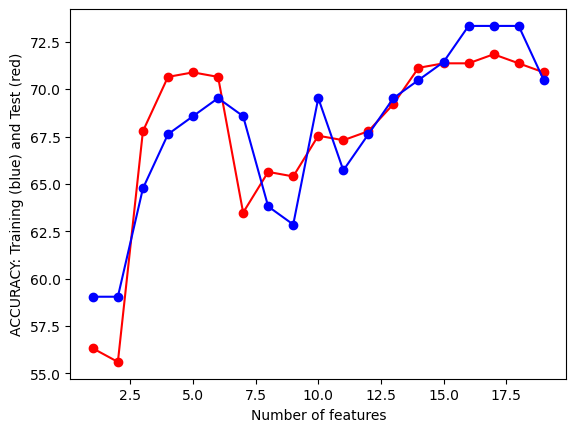

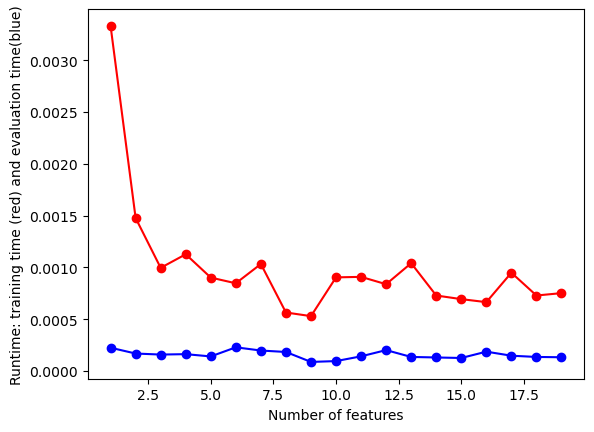

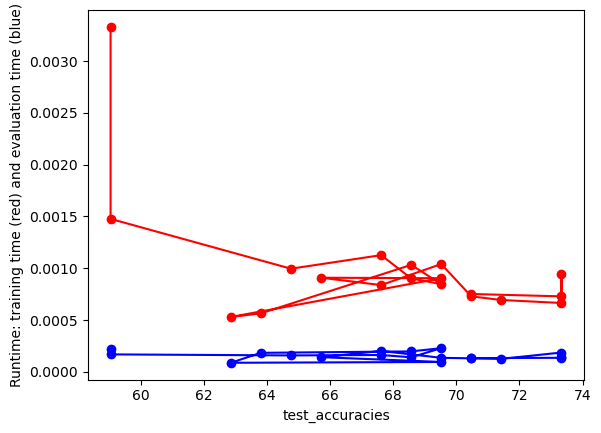

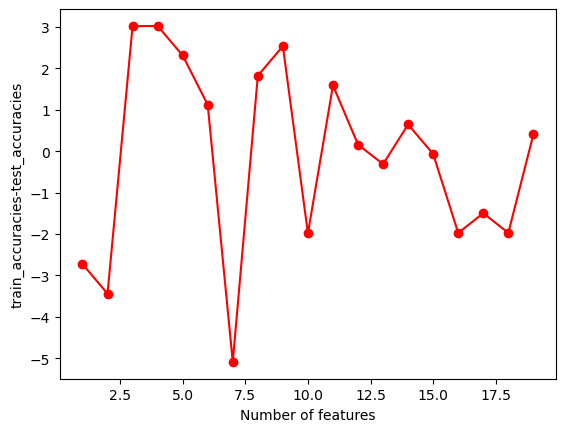

In [170]:
output_dir = "../results/naive-bayes/"
save_results(output_dir+"/partial_grid_search")
plot_results(output_dir+"/partial_grid_search")

In [125]:
# INITIALIZE ARRAYS
initialize_arrays()

# FIRST FEATURE 
features=[random.randint(0, x.shape[1]-1)]; #print(features)
max_iter=19

# STORE ATTEMPTS
already_tried=[]

for iter in range(0,max_iter):
    if iter%1==0: print(iter,len(features),len(already_tried))
    if(iter==0):
        xtmp=x[:,features]
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
        acc_train_im1=acc_train
    else:
        didnt_find=True
        while(didnt_find or len(features)+len(already_tried)>0.8*x.shape[1]):
            # NEW TRIAL FEATURE  
            new_feature=random.randint(0, x.shape[1]-1)
            if new_feature not in features and new_feature not in already_tried:
                # ADD NEW TRIAL FEATURE FROM LIST
                features.append(new_feature); 
                # FEATURE SUBSET
                xtmp=x[:,features]

                # TRAIN 
                (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

                # ACCEPTANCE CRITERION 
                if(acc_train-acc_train_im1>0):
                    #print(features)
                    acc_train_im1=acc_train                    
                    #RECORD 
                    num_features.append(xtmp.shape[1])
                    train_accuracies.append(acc_train)
                    test_accuracies.append(acc_test)
                    train_time.append(time_train)
                    eval_time.append(time_eval)

                    didnt_find=False
                else:
                    # RECORD ATTEMPT
                    already_tried.append(new_feature)

                    # REMOVE NEW TRIAL FEATURE FROM LIST
                    features.pop()

0 1 0
1 1 0
2 2 8
3 3 9
4 4 9
5 5 9
6 6 9


KeyboardInterrupt: 

In [ ]:
# CHECK RESULTS 
save_results(output_dir+"/random_search")
plot_results(output_dir+"/random_search")

In [171]:
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.013777621322713766
0.24996722218984915


In [172]:
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 0.021922090318132227 17
THRESHOLD = 0.03006655931355069 17
THRESHOLD = 0.03821102830896915 16
THRESHOLD = 0.04635549730438761 15
THRESHOLD = 0.054499966299806066 14
THRESHOLD = 0.06264443529522454 13
THRESHOLD = 0.070788904290643 13
THRESHOLD = 0.07893337328606145 13
THRESHOLD = 0.08707784228147991 10
THRESHOLD = 0.09522231127689837 10
THRESHOLD = 0.10336678027231684 10
THRESHOLD = 0.1115112492677353 10
THRESHOLD = 0.11965571826315376 10
THRESHOLD = 0.12780018725857223 10
THRESHOLD = 0.1359446562539907 10
THRESHOLD = 0.14408912524940914 10
THRESHOLD = 0.1522335942448276 10
THRESHOLD = 0.16037806324024606 10
THRESHOLD = 0.16852253223566452 10
THRESHOLD = 0.17666700123108298 10
THRESHOLD = 0.18481147022650146 9
THRESHOLD = 0.19295593922191992 9
THRESHOLD = 0.20110040821733838 8
THRESHOLD = 0.20924487721275684 7
THRESHOLD = 0.2173893462081753 6
THRESHOLD = 0.22553381520359375 5
THRESHOLD = 0.2336782841990122 5


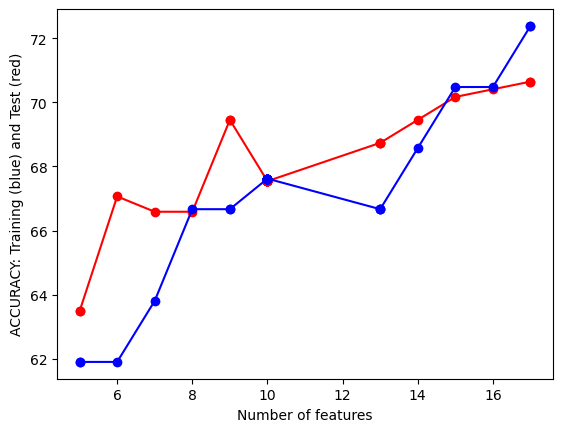

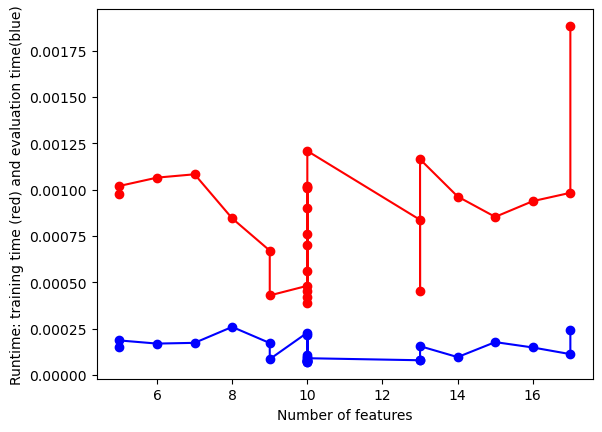

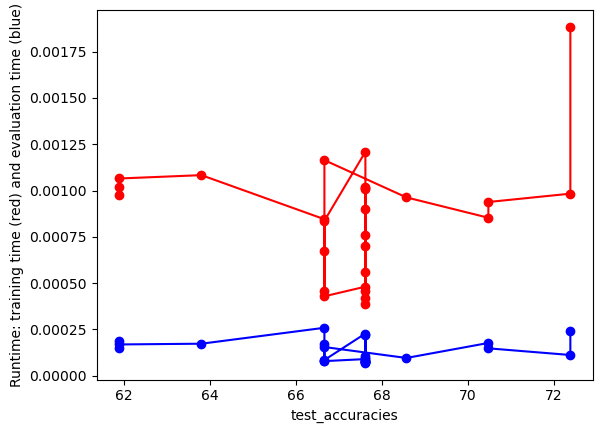

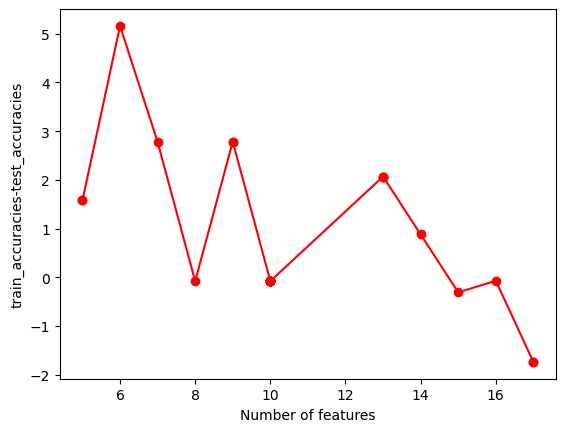

In [173]:
# CHECK RESULTS 
save_results(output_dir+"/variance_threshold")
plot_results(output_dir+"/variance_threshold")

## Feature Selection for Text Data

In [271]:
# convert string labels in reddit_text.label to integers
# 0 = weed, 1 = psychosis, 2 = schizophrenia
reddit_text.dropna(inplace=True)
reddit_text['label'] = reddit_text['label'].replace(['weed', 'Psychosis', 'schizophrenia'], [0, 1, 2])
y = reddit_text['label'].to_numpy()

In [259]:
# PARAMETERS TO CONTROL SIZE OF FEATURE SPACE WITH COUNT-VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
# max_features=int, default=None
#   If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

from sklearn.feature_extraction.text import CountVectorizer

def vectorize(corpus,MAX_FEATURES):
    vectorizer=CountVectorizer(max_features=MAX_FEATURES,stop_words="english")   
    # RUN COUNT VECTORIZER ON OUR COURPUS 
    Xs  =  vectorizer.fit_transform(corpus)   
    X=np.array(Xs.todense())
    #CONVERT TO ONE-HOT VECTORS (can also be done with binary=true in CountVectorizer)
    maxs=np.max(X,axis=0)
    return (np.ceil(X/maxs),vectorizer.vocabulary_)

(x,vocab0)=vectorize(reddit_text['text'],MAX_FEATURES=10000)

In [260]:
#swap keys and values (value --> key)
vocab1 = dict([(value, key) for key, value in vocab0.items()])
#RE-ORDER COLUMN SO IT IS SORTED FROM HIGH FREQ TERMS TO LOW 
# https://stackoverflow.com/questions/60758625/sort-pandas-dataframe-by-sum-of-columns
df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
print(df2.head())

   937   1099  791   495   311   1433  1600  1011  1299  1442  ...  644   \
0   1.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   629   643   641   639   638   636   635   632   1609  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1610 columns]


In [261]:
# REMAP DICTIONARY TO CORRESPOND TO NEW COLUMN NUMBERS
print()
i1=0
vocab2={}
for i2 in list(df2.columns):
    # print(i2)
    vocab2[i1]=vocab1[int(i2)]
    i1+=1

#DOUBLE CHECK 
print(vocab2[0],vocab1[643])
print(vocab2[1],vocab1[2])


numbr hopeful
psychosis absolutely


In [262]:
# RENAME COLUMNS 0,1,2,3 .. 
df2.columns = range(df2.columns.size)
print(df2.head())
print(df2.sum(axis=0))
x=df2.to_numpy()

   0     1     2     3     4     5     6     7     8     9     ...  1600  \
0   1.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   1601  1602  1603  1604  1605  1606  1607  1608  1609  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1610 columns]
0       4500.0
1       3800.0
2       3800.0
3       3100.0
4       2700.0
         ...  
1605     100.0
1606     100.0
1607     100.0
1608     100.0
1609     100.0
Lengt

In [263]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:] # last 20% of shuffled list

print(train_index[0:10])
print(test_index[0:10])

[26323, 23215, 16763, 2468, 15662, 12383, 19344, 4685, 29639, 2583]
[3293, 24500, 28662, 13071, 1827, 2764, 10425, 14129, 14017, 12574]


In [180]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(29700, 1610) (29700,)
(29700, 1610) (29700,)
91.91077441077441 91.95286195286195 17.717603000000054 0.4340500000002976


In [183]:
# INITIALIZE ARRAYS
initialize_arrays()
# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

1 10 10 53.26599326599326 54.612794612794616
2 20 20 61.30050505050505 62.878787878787875
3 30 30 64.29292929292929 66.06060606060606
4 40 40 65.94276094276094 67.87878787878789
5 50 50 67.0496632996633 68.5016835016835
6 60 60 66.38047138047139 67.8114478114478
7 70 70 70.05892255892256 71.6161616161616
8 80 80 71.82659932659932 72.96296296296296
9 90 90 72.81986531986531 74.04040404040404
10 100 100 73.16077441077441 74.36026936026936
11 110 110 72.82828282828284 74.006734006734
12 120 120 72.10437710437711 73.53535353535354
13 130 130 72.18434343434343 73.21548821548821
14 140 140 73.14393939393939 74.42760942760943
15 150 150 73.12710437710437 74.4949494949495
16 160 160 73.16498316498317 74.34343434343434
17 170 170 74.52020202020202 75.65656565656566
18 180 180 74.52020202020202 75.65656565656566
19 190 190 74.53282828282828 75.60606060606061
20 200 200 75.19781144781145 76.31313131313131
21 210 210 75.19781144781145 76.31313131313131
22 220 220 75.19781144781145 76.3131313131313

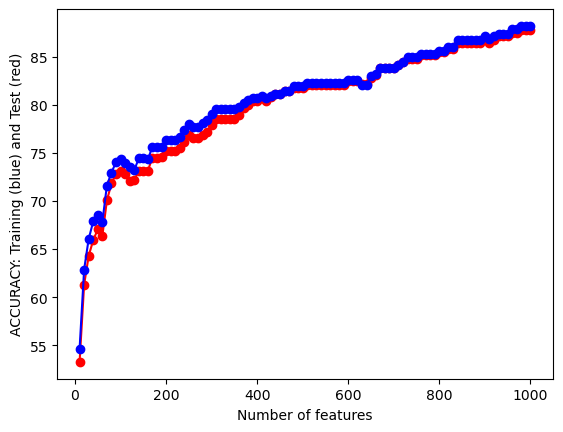

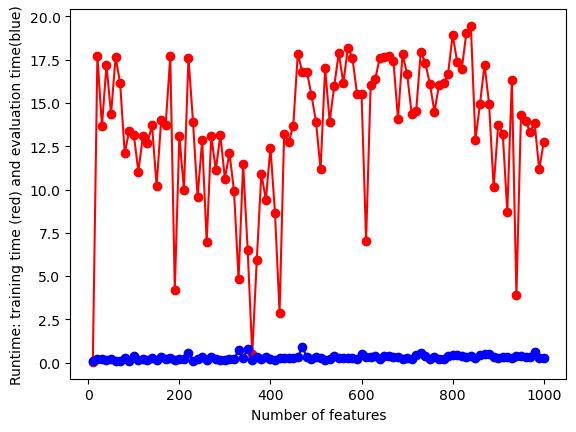

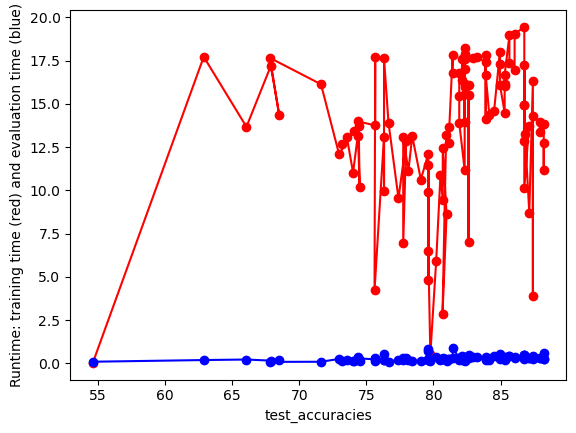

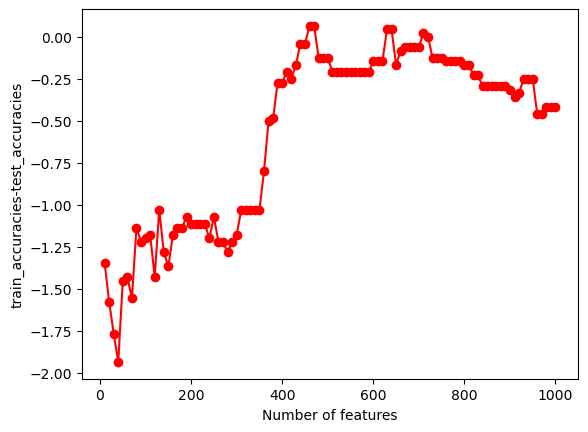

In [184]:
save_results(output_dir+"/partial_grid_search_text")
plot_results(output_dir+"/partial_grid_search_text")

In [ ]:
# INITIALIZE ARRAYS
initialize_arrays()

# FIRST FEATURE 
features=[random.randint(0, x.shape[1])]; #print(features)
max_iter=500

# STORE ATTEMPTS
already_tried=[]

for iter in range(0,max_iter):
    if iter%50==0: print(iter,len(features),len(already_tried))
    if(iter==0):
        xtmp=x[:,features]
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
        acc_train_im1=acc_train
    else:
        didnt_find=True
        while(didnt_find or len(features)+len(already_tried)>0.8*x.shape[1]):
            # NEW TRIAL FEATURE  
            new_feature=random.randint(0, x.shape[1])
            if new_feature not in features and new_feature not in already_tried:
                # ADD NEW TRIAL FEATURE FROM LIST
                features.append(new_feature); 
                # FEATURE SUBSET
                xtmp=x[:,features]

                # TRAIN 
                (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

                # ACCEPTANCE CRITERION 
                if(acc_train-acc_train_im1>0):
                    #print(features)
                    acc_train_im1=acc_train                    
                    #RECORD 
                    num_features.append(xtmp.shape[1])
                    train_accuracies.append(acc_train)
                    test_accuracies.append(acc_test)
                    train_time.append(time_train)
                    eval_time.append(time_eval)

                    didnt_find=False
                else:
                    # RECORD ATTEMPT
                    already_tried.append(new_feature)

                    # REMOVE NEW TRIAL FEATURE FROM LIST
                    features.pop()

In [ ]:
# CHECK RESULTS 
save_results(output_dir+"/random_search_text")
plot_results(output_dir+"/random_search_text")

In [185]:
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.0033556666553305145
0.1285583103765079


In [186]:
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 0.00767299919744008 295
THRESHOLD = 0.011990331739549644 186
THRESHOLD = 0.01630766428165921 136
THRESHOLD = 0.020624996823768775 76
THRESHOLD = 0.02494232936587834 64
THRESHOLD = 0.029259661907987903 58
THRESHOLD = 0.033576994450097465 40
THRESHOLD = 0.03789432699220703 35
THRESHOLD = 0.042211659534316597 28
THRESHOLD = 0.04652899207642616 24
THRESHOLD = 0.05084632461853573 21
THRESHOLD = 0.05516365716064529 16
THRESHOLD = 0.05948098970275485 14
THRESHOLD = 0.06379832224486442 12
THRESHOLD = 0.068115654786974 10
THRESHOLD = 0.07243298732908356 6
THRESHOLD = 0.07675031987119312 6
THRESHOLD = 0.08106765241330269 5
THRESHOLD = 0.08538498495541225 4
THRESHOLD = 0.08970231749752182 4
THRESHOLD = 0.09401965003963138 3
THRESHOLD = 0.09833698258174095 3
THRESHOLD = 0.10265431512385051 3
THRESHOLD = 0.10697164766596007 3
THRESHOLD = 0.11128898020806964 3
THRESHOLD = 0.1156063127501792 1
THRESHOLD = 0.11992364529228877 1


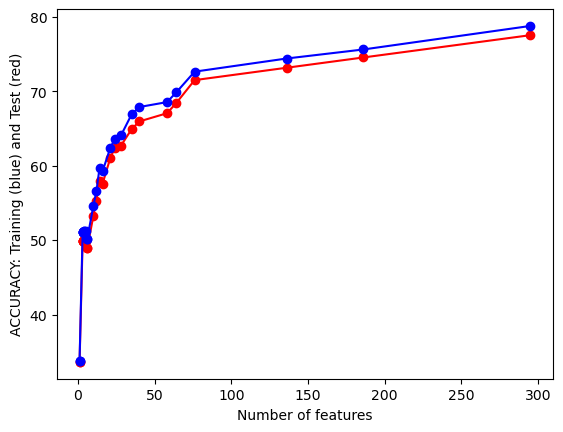

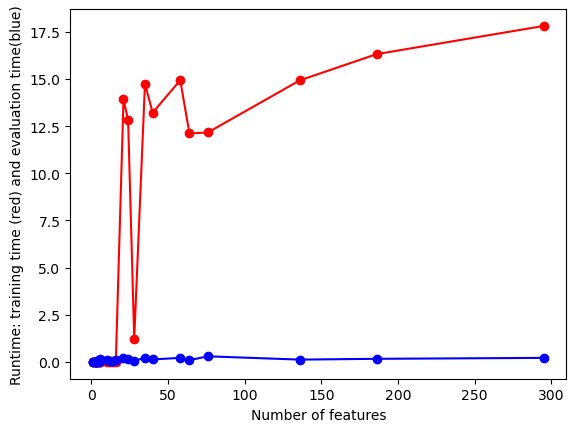

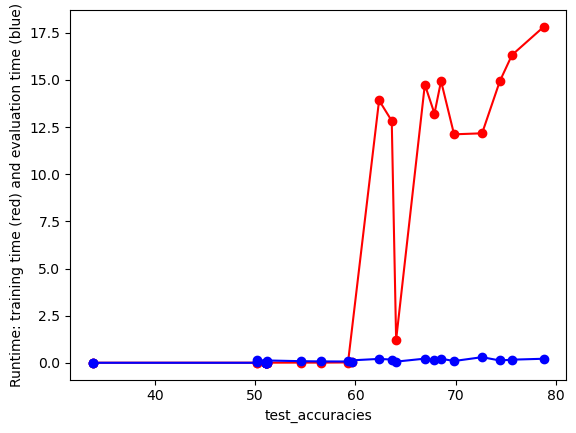

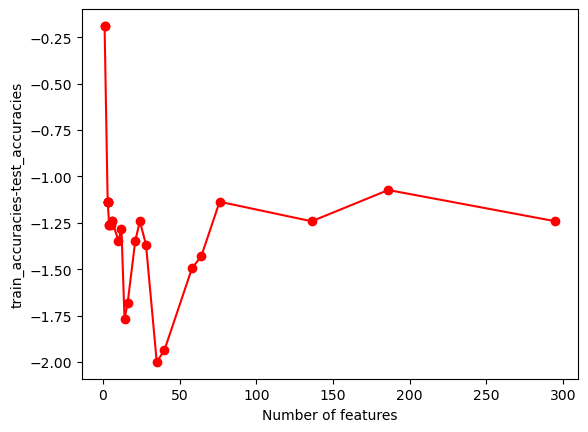

In [187]:
# CHECK RESULTS 
save_results(output_dir+"/variance_threshold_text")
plot_results(output_dir+"/variance_threshold_text")

## Naïve Bayes with Labeled Record Data

Now that we have look at some feature selection with Naïve Bayes, let's try to predict whether an individual uses cannabis using our psychosis data. We will use a Bernoulli Naïve Bayes model because our target is binary.

First, we can take the optimal feature set from our record data, `full_data`, based on our feature selection above.
Using the elbow method from the partial grid search, we see that the optimal number of features is 5 with a train accuracy of 70.88% and a test accuracy of 68.57%. We will use this feature set for our Bernoulli Naïve Bayes model.


In [247]:
x = full_data.drop(['CannabisBinary', 'code', 'Program'], axis=1).to_numpy()
y = full_data['CannabisBinary'].to_numpy()

In [248]:
upper_index=0+5*int((19-0)/19)
x=x[:,0:upper_index]

Recall that we have already split the data into a training, validation, and test set. Let's use the training set to train our model and the validation set to tune our model. Then, we can assess the model's performance using the test set.

In [249]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:]

#SPLIT
x_train=x[train_index]
y_train=y[train_index].flatten()

x_test=x[test_index]
y_test=y[test_index].flatten()

bnb = BernoulliNB()

# Train the model
bnb.fit(x_train, y_train)

# Predict on test set
y_pred = bnb.predict(x_test)
y_pred_prob = bnb.predict_proba(x_test)

# Print accuracy, precision, recall, and F1 score
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted') * 100))
print("F1: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted') * 100))

Accuracy: 80.00%
Precision: 83.74%
Recall: 80.00%
F1: 79.63%


After training our model to approximate $P(X|Y)$ and using a prior for $P(Y)$, we make predictions on our test set. The predictions are made by calculating the probability of the input value given each class based on our training data. The class with the highest probability is then returned as the prediction.

To evaluate our model, we use accuracy, precision, recall, and F1 score. Accuracy tells us how many of our predictions are correct. Precision indicates how many of our positive prediction (i.e. that an individual uses cannabis) are correct. Recall indicates how many of the true positives we correctly identified with our model. F1 score averages precision and recall. Our precision and recall are very similar to our accuracy, meaning our model isn't simply predicting everything as one class. This also indicates that our data is well stratified into the two classes with an even balance of positive and negative cases. Our accuracy is relatively high at 80.00%, with a very similar F1 score of 79.63%.

The findings of this project will be maintained in a [GitHub repository](https://github.com/anly501/dsan-5000-project-mfgeary) as well as this [website](https://mgb.georgetown.domains/5000-website/_site/). I will also present my findings in a presentation to the class in December 2023.

Our findings mean that we can predict whether an individual uses cannabis with about 80% accuracy based on their mental health and psychosis history. This is a fairly high accuracy. Using these results, we gain evidence that there is a relationship between cannabis use and psychosis. We will continue to explore this relationship in the next section of the project.

[[48  2]
 [19 36]]


Text(0.5, 1.0, 'Confusion Matrix of Naive\nBayes Classifier for Cannabis Usage')

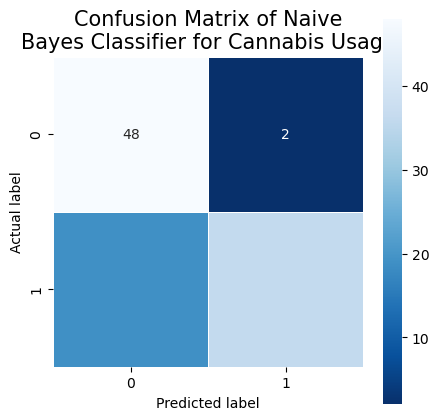

In [250]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
print(cm)

# plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, linewidths=.5, square=True, cmap='Blues_r', annot=True, fmt='d')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.title('Confusion Matrix of Naive\nBayes Classifier for Cannabis Usage', size=15)

By looking at this confusion matrix, we see that our model minimizes the number of false negatives and false positives. This means that our recall and precision are fairly high. However, we see that about 20% of our data is getting misclassified, so we will continue to explore other models to see if we can improve our accuracy in future sections of the project.

Text(0.5, 1.0, 'ROC Curve of Naive\nBayes Classifier for Cannabis Usage')

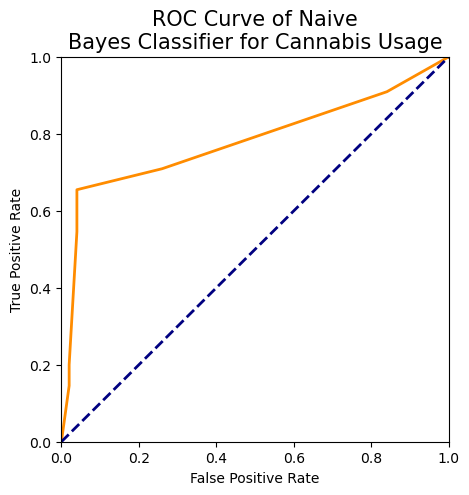

In [253]:
# ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:.2f}%)'.format(roc_auc * 100))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Naive\nBayes Classifier for Cannabis Usage', size=15)

In [254]:
roc_auc

0.780909090909091

By looking at the ROC curve, we see that our model is better than one that makes predictions at random with an AUC score of 0.79. This means that our model generally predicts true positives while limiting false positives, although another model may perform better.

Overall, our model performs well by classifying individuals who use cannabis with an accuracy of 80%. The model is likely not overfit because the accuracy on the test and training sets are very similar. An overfit model would have a high accuracy on the training set and a low accuracy on the test set.

Generally, our model gives more indication that there is a link between psychosis and cannabis use. This model shows that psychosis and mental health data is a fairly good predictor of cannabis usage. We will continue to explore this relationship in the next section of the project.

## Naïve Bayes with Labeled Text Data

Now that we have look at some feature selection with Naïve Bayes, let's try to predict which subreddit a post belongs to using our text data. We will use a Multinomial Naïve Bayes model because our target is multiclass.

We will use the optimal feature set derived in the earlier analysis using the partial grid search. Using the elbow method from the partial grid search, we see that the optimal number of features is 250 with a train accuracy of 76.89% and a test accuracy of 77.96%. We will use this feature set for our Multinomial Naïve Bayes model.


In [264]:
upper_index=0+25*int((1000-0)/100)
x=x[:,0:upper_index]

In [269]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:]

In [272]:
#SPLIT
x_train=x[train_index]
y_train=y[train_index].flatten()

x_test=x[test_index]
y_test=y[test_index].flatten()

mnb = MultinomialNB()

# Train the model
mnb.fit(x_train, y_train)

# Predict on test set
y_pred = mnb.predict(x_test)
y_pred_prob = mnb.predict_proba(x_test)

# Print accuracy, precision, recall, and F1 score
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted') * 100))
print("F1: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted') * 100))

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
print(cm)

# plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, linewidths=.5, square=True, cmap='Blues_r', annot=True, fmt='d')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.title('Confusion Matrix of Naive\nBayes Classifier for Subreddit Text', size=15)




In [ ]:

# ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:.2f}%)'.format(roc_auc * 100))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve of Naive\nBayes Classifier for Subreddit Text', size=15)

roc_auc